In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers

In [3]:
def lin_on_axis(X, weights, bias=0, axis=-1):
    "Apply a linear layer to a particular axis in an n-dimensional array."
    # (I found einsum slightly faster than [transpose->matmul->transpose])

    A = 'abcdefghijklmnopqrstuvwxyz'
    
    ndim = len(X.shape)
    assert ndim <= len(A), 'Too many dimensions.'

    axis = axis if axis >= 0 else ndim + axis
    assert axis >= 0 and axis < ndim, f'Invalid axis: {axis}, for ndim: {ndim}'

    s1 = ''.join(A[i] for i in range(ndim))
    s2 = ''.join(s1[axis] + A[ndim])
    s3 = ''.join(A[i] if i != axis else A[ndim] for i in range(ndim))

    if tf.is_tensor(bias):
        bias_shape = [1 if i != axis else bias.shape[0] for i in range(ndim)]
        bias = tf.reshape(bias, bias_shape)
    
    return tf.einsum(f'{s1},{s2}->{s3}', X, weights, optimize='auto') + bias

class DenseOnAxis(layers.Layer):
    "Dense layer that is applied to a particular axis of an ndarray."

    def __init__(self, units, axis=-1, activation=lambda x: x):
        super().__init__()
        self.units = units
        self.axis = axis
        self.activation = activation

    def build(self, input_shape):
        self.w = self.add_weight(shape=[input_shape[self.axis], self.units],
                                initializer='he_uniform',
                                trainable=True)
        self.b = self.add_weight(shape=[self.units],
                                initializer='zeros',
                                trainable=True)

    def call(self, inputs):
        h = lin_on_axis(inputs, self.w, self.b, self.axis)
        return self.activation(h)

class MLPOnAxis(layers.Layer):
    "Multilayer perceptron that is applied to a particular axis of an ndarray."

    def __init__(self, outsize, axis=-1, hidden_size=None, activation=tf.nn.gelu):
        super().__init__()
        hidden_size = hidden_size if hidden_size else outsize
        self.layer_1 = DenseOnAxis(hidden_size, axis, activation)
        self.layer_2 = DenseOnAxis(outsize, axis)

    def call(self, inputs):
        h = self.layer_1(inputs)
        return self.layer_2(h)

class NdMixer(layers.Layer):
    "N-dimensional MLP-mixer, without batchnorm or skip connections."

    def __init__(self, outshape, Net=MLPOnAxis, gate=True):
        """ 
        Args:
            outshape (tuple/list):
                The output shape, not including the samples dimension.
            Net (layers.Layer):
                A dense-like layer, that operates on a particular axis.
            gate (bool):
                Whether to gate the output (with a learnable scalar),
                in order to initialise as the identify function. 
        """
        super().__init__()
        self.ndim = len(outshape)
        self.nets = [Net(size, axis=i+1) for i, size in enumerate(outshape)] 
        self.gate = ScalarGate() if gate else lambda x: x

    def call(self, inputs):
        h = inputs
        for net in self.nets:
            h = net(h)
        return self.gate(h)

class Layers(layers.Layer):
    def __init__(self, num_layers, make_layer):
        super().__init__()
        self.layers = [make_layer() for _ in range(num_layers)]
    
    def call(self, inputs):
        h = inputs
        for layer in self.layers:
            h = layer(h)
        return h

class ResidualLayers(layers.Layer):
    def __init__(self, num_layers, make_layer):
        super().__init__()
        self.layers = [make_layer() for _ in range(num_layers)]

    def call(self, inputs):  # momentum ResNets
        h = inputs
        for layer in self.layers:
            h = h + layer(h)
        return h

class ScalarGate(layers.Layer):
    def __init__(self):
        super().__init__()
        self.value = tf.Variable(0.0, trainable=True)

    def call(self, inputs):
        return self.value * inputs
    

In [22]:
def MixerClf(in_shape, repr_shape, out_shape, num_mix_layers, hidden_size=None):
    Net = lambda outsize, axis: MLPOnAxis(outsize, axis, hidden_size)
    make_mixer = lambda: NdMixer(repr_shape, Net, gate=True)

    inputs = layers.Input(in_shape)
    repr_init = NdMixer(repr_shape, Net=DenseOnAxis, gate=False)(inputs)
    mixed = ResidualLayers(num_mix_layers, make_mixer)(repr_init)
    repr_final = NdMixer(out_shape, Net=DenseOnAxis, gate=False)(mixed)
    h = layers.Flatten()(repr_final)
    h = layers.Dense(num_classes)(h)
    return tf.keras.Model(inputs=inputs, outputs=h)


def MixerAutoencoder(in_shape, repr_shape, num_mix_layers, hidden_size=None):
    Net = lambda outsize, axis: MLPOnAxis(outsize, axis, hidden_size)
    make_mixer = lambda: NdMixer(repr_shape, Net, gate=True)

    inputs = layers.Input(in_shape)
    repr_init = NdMixer(repr_shape, Net=Net, gate=False)(inputs)
    mixed = ResidualLayers(num_mix_layers, make_mixer)(repr_init)
    repr_final = NdMixer(in_shape, Net=Net, gate=False)(mixed)
    return tf.keras.Model(inputs=inputs, outputs=repr_final)


# MNIST

In [5]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0
train_images, test_images = train_images.astype(np.float32), test_images.astype(np.float32)

height, width = train_images.shape[-2:]
num_classes = 10

11493376/11490434 [==============================] - 0s 0us/step


In [6]:
# Assert that the model is initialised as identify function.
num_mix_layers = 16
make_mixer = lambda: NdMixer([height, width], MLPOnAxis, gate=True)
inputs = tf.keras.layers.Input(shape=(height, width))
mixer_layers = ResidualLayers(num_mix_layers, make_mixer)(inputs)
model = tf.keras.Model(inputs=inputs, outputs=mixer_layers)
assert np.sum(model.predict(train_images[0:100, ...]) - train_images[0:100, ...]) == 0

## Autoencoder

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 28, 28)]          0         
_________________________________________________________________
mlp_on_axis_140 (MLPOnAxis)  (None, 28, 28)            1624      
_________________________________________________________________
mlp_on_axis_141 (MLPOnAxis)  (None, 28, 28)            1624      
_________________________________________________________________
residual_layers_12 (Residual (None, 28, 28)            12996     
_________________________________________________________________
mlp_on_axis_150 (MLPOnAxis)  (None, 28, 28)            1624      
_________________________________________________________________
mlp_on_axis_151 (MLPOnAxis)  (None, 28, 28)            1624      
Total params: 19,492
Trainable params: 19,492
Non-trainable params: 0
______________________________________________________

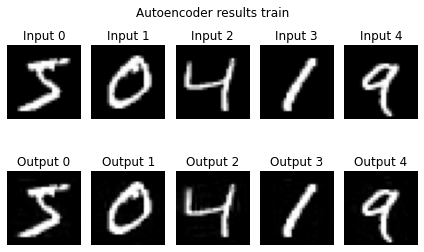

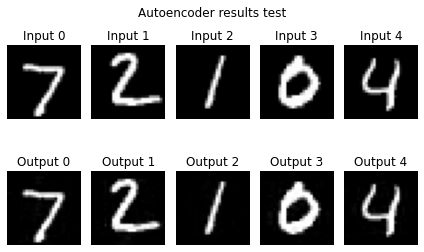

In [23]:
num_mix_layers = 4
in_shape = (height, width)
repr_shape = (height, width)

model = MixerAutoencoder(in_shape, repr_shape, num_mix_layers)

print(model.summary())
model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(train_images, train_images, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_images), verbose=2)

# PLOTS
plt.plot(history.history['root_mean_squared_error'], label='root_mean_squared_error')
plt.plot(history.history['val_root_mean_squared_error'], label = 'val_root_mean_squared_error')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.ylim([0, .2])
plt.legend()
test_loss, test_acc = model.evaluate(test_images,  test_images, verbose=2)

for i in range(5):
    im = train_images[i:i+1,...]

    plt.subplot(2, 5, i+1)
    plt.imshow(im[0,...], cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.title(f'Input {i}')

    plt.subplot(2, 5, i+6)
    plt.imshow(model.predict(im)[0,...], cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.title(f'Output {i}')

plt.suptitle("Autoencoder results train")
plt.tight_layout()
plt.show()

for i in range(5):
    im = test_images[i:i+1,...]

    plt.subplot(2, 5, i+1)
    plt.imshow(im[0,...], cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.title(f'Input {i}')

    plt.subplot(2, 5, i+6)
    plt.imshow(model.predict(im)[0,...], cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.title(f'Output {i}')

plt.suptitle("Autoencoder results test")
plt.tight_layout()
plt.show()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 28, 28)]          0         
_________________________________________________________________
mlp_on_axis_152 (MLPOnAxis)  (None, 4, 28)             8452      
_________________________________________________________________
mlp_on_axis_153 (MLPOnAxis)  (None, 4, 4)              8452      
_________________________________________________________________
residual_layers_13 (Residual (None, 4, 4)              18468     
_________________________________________________________________
mlp_on_axis_162 (MLPOnAxis)  (None, 28, 4)             8476      
_________________________________________________________________
mlp_on_axis_163 (MLPOnAxis)  (None, 28, 28)            8476      
Total params: 52,324
Trainable params: 52,324
Non-trainable params: 0
______________________________________________________

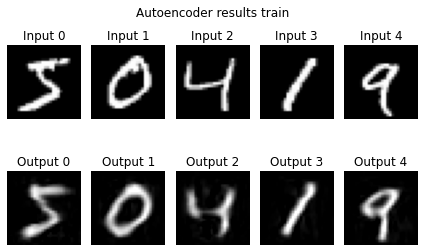

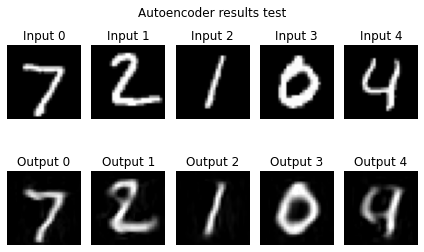

In [24]:
"Using a much smaller hidden representation, but larger hidden size."

num_mix_layers = 4
in_shape = (height, width)
repr_shape = (4, 4)

model = MixerAutoencoder(in_shape, repr_shape, num_mix_layers, hidden_size=256)

print(model.summary())
model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(train_images, train_images, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_images), verbose=2)

# PLOTS
plt.plot(history.history['root_mean_squared_error'], label='root_mean_squared_error')
plt.plot(history.history['val_root_mean_squared_error'], label = 'val_root_mean_squared_error')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.ylim([0, .2])
plt.legend()
test_loss, test_acc = model.evaluate(test_images,  test_images, verbose=2)

for i in range(5):
    im = train_images[i:i+1,...]

    plt.subplot(2, 5, i+1)
    plt.imshow(im[0,...], cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.title(f'Input {i}')

    plt.subplot(2, 5, i+6)
    plt.imshow(model.predict(im)[0,...], cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.title(f'Output {i}')

plt.suptitle("Autoencoder results train")
plt.tight_layout()
plt.show()

for i in range(5):
    im = test_images[i:i+1,...]

    plt.subplot(2, 5, i+1)
    plt.imshow(im[0,...], cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.title(f'Input {i}')

    plt.subplot(2, 5, i+6)
    plt.imshow(model.predict(im)[0,...], cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.title(f'Output {i}')

plt.suptitle("Autoencoder results test")
plt.tight_layout()
plt.show()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 28, 28)]          0         
_________________________________________________________________
mlp_on_axis_184 (MLPOnAxis)  (None, 8, 28)             304       
_________________________________________________________________
mlp_on_axis_185 (MLPOnAxis)  (None, 8, 8)              304       
_________________________________________________________________
residual_layers_15 (Residual (None, 8, 8)              1156      
_________________________________________________________________
mlp_on_axis_194 (MLPOnAxis)  (None, 28, 8)             1064      
_________________________________________________________________
mlp_on_axis_195 (MLPOnAxis)  (None, 28, 28)            1064      
Total params: 3,892
Trainable params: 3,892
Non-trainable params: 0
________________________________________________________

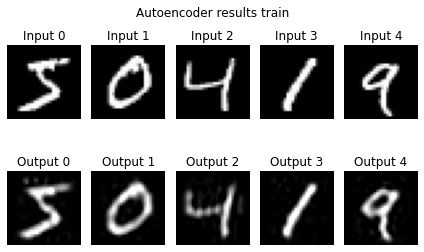

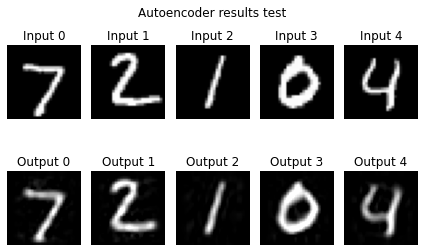

In [26]:
"Less small hidden representation, small hidden size."

num_mix_layers = 4
in_shape = (height, width)
repr_shape = (8, 8)

model = MixerAutoencoder(in_shape, repr_shape, num_mix_layers, hidden_size=None)

print(model.summary())
model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(train_images, train_images, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_images), verbose=2)

# PLOTS
plt.plot(history.history['root_mean_squared_error'], label='root_mean_squared_error')
plt.plot(history.history['val_root_mean_squared_error'], label = 'val_root_mean_squared_error')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.ylim([0, .2])
plt.legend()
test_loss, test_acc = model.evaluate(test_images,  test_images, verbose=2)

for i in range(5):
    im = train_images[i:i+1,...]

    plt.subplot(2, 5, i+1)
    plt.imshow(im[0,...], cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.title(f'Input {i}')

    plt.subplot(2, 5, i+6)
    plt.imshow(model.predict(im)[0,...], cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.title(f'Output {i}')

plt.suptitle("Autoencoder results train")
plt.tight_layout()
plt.show()

for i in range(5):
    im = test_images[i:i+1,...]

    plt.subplot(2, 5, i+1)
    plt.imshow(im[0,...], cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.title(f'Input {i}')

    plt.subplot(2, 5, i+6)
    plt.imshow(model.predict(im)[0,...], cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.title(f'Output {i}')

plt.suptitle("Autoencoder results test")
plt.tight_layout()
plt.show()

## Classifier

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 28, 28)]          0         
_________________________________________________________________
dense_on_axis_430 (DenseOnAx (None, 28, 28)            812       
_________________________________________________________________
dense_on_axis_431 (DenseOnAx (None, 28, 28)            812       
_________________________________________________________________
residual_layers_16 (Residual (None, 28, 28)            12996     
_________________________________________________________________
dense_on_axis_448 (DenseOnAx (None, 1, 28)             29        
_________________________________________________________________
dense_on_axis_449 (DenseOnAx (None, 1, 28)             812       
_________________________________________________________________
flatten_5 (Flatten)          (None, 28)                0  

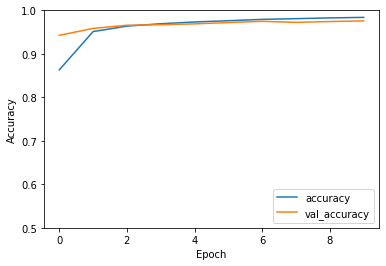

In [27]:
"Train a small mixer on MNIST."

num_mix_layers = 4
in_shape = (height, width)
repr_shape = (height, width)
out_shape = (1, 28)

model = MixerClf(in_shape, repr_shape, out_shape, num_mix_layers)

print(model.summary())
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_labels), verbose=2)

# PLOTS
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([.5, 1])
plt.legend(loc='lower right')
plt.show()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 28, 28)]          0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 28, 28)         0         
_________________________________________________________________
model_19 (Functional)        (None, 10)                14196     
Total params: 14,196
Trainable params: 14,196
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
938/938 - 10s - loss: 0.5841 - accuracy: 0.8112 - val_loss: 0.2524 - val_accuracy: 0.9210
Epoch 2/10
938/938 - 7s - loss: 0.2264 - accuracy: 0.9312 - val_loss: 0.2253 - val_accuracy: 0.9273
Epoch 3/10
938/938 - 7s - loss: 0.1764 - accuracy: 0.9463 - val_loss: 0.1663 - val_accuracy: 0.9479
Epoch 4/10
938/938 - 7s - loss: 0.1473 - accuracy: 0.9546 - val_loss: 0.1582 -

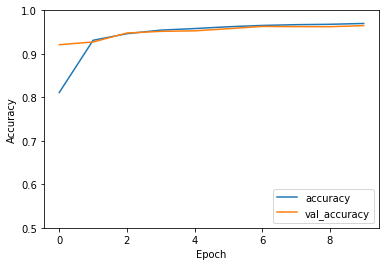

In [28]:
"Playing with the dimensionality (with larger hidden size)."

num_mix_layers = 4
in_shape = (1, height, width)
repr_shape = (8, 8, 8)
out_shape = (28, 1, 1)

inputs = layers.Input((height, width))
h = layers.Reshape(in_shape)(inputs)
h = MixerClf(in_shape, repr_shape, out_shape, num_mix_layers, hidden_size=64)(h)
model = tf.keras.Model(inputs=inputs, outputs=h)

print(model.summary())
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_labels), verbose=2)

# PLOTS
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([.5, 1])
plt.legend(loc='lower right')
plt.show()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 28, 28)]          0         
_________________________________________________________________
dense_on_axis_480 (DenseOnAx (None, 4, 28)             116       
_________________________________________________________________
dense_on_axis_481 (DenseOnAx (None, 4, 4)              116       
_________________________________________________________________
residual_layers_18 (Residual (None, 4, 4)              324       
_________________________________________________________________
dense_on_axis_498 (DenseOnAx (None, 4, 4)              20        
_________________________________________________________________
dense_on_axis_499 (DenseOnAx (None, 4, 4)              20        
_________________________________________________________________
flatten_7 (Flatten)          (None, 16)                0  

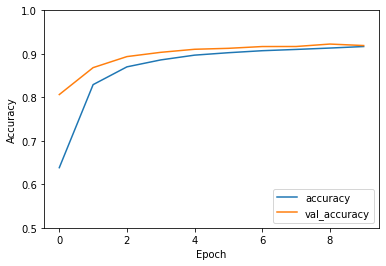

In [29]:
"Using a smaller representation size."

num_mix_layers = 4
in_shape = (height, width)
repr_shape = (4, 4)
out_shape = (4, 4)

model = MixerClf(in_shape, repr_shape, out_shape, num_mix_layers)

print(model.summary())
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_labels), verbose=2)

# PLOTS
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([.5, 1])
plt.legend(loc='lower right')
plt.show()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 28, 28)]          0         
_________________________________________________________________
dense_on_axis_500 (DenseOnAx (None, 64, 28)            1856      
_________________________________________________________________
dense_on_axis_501 (DenseOnAx (None, 64, 64)            1856      
_________________________________________________________________
residual_layers_19 (Residual (None, 64, 64)            66564     
_________________________________________________________________
dense_on_axis_518 (DenseOnAx (None, 1, 64)             65        
_________________________________________________________________
dense_on_axis_519 (DenseOnAx (None, 1, 12)             780       
_________________________________________________________________
flatten_8 (Flatten)          (None, 12)                0  

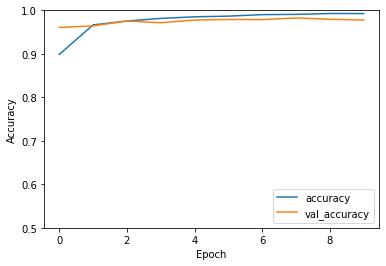

In [30]:
"Using a larger representation size."

num_mix_layers = 4
in_shape = (height, width)
repr_shape = (64, 64)
out_shape = (1, 12)

model = MixerClf(in_shape, repr_shape, out_shape, num_mix_layers)

print(model.summary())
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_labels), verbose=2)

# PLOTS
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([.5, 1])
plt.legend(loc='lower right')
plt.show()

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 28, 28)]          0         
_________________________________________________________________
dense_on_axis_520 (DenseOnAx (None, 4, 28)             116       
_________________________________________________________________
dense_on_axis_521 (DenseOnAx (None, 4, 4)              116       
_________________________________________________________________
residual_layers_20 (Residual (None, 4, 4)              36900     
_________________________________________________________________
dense_on_axis_538 (DenseOnAx (None, 4, 4)              20        
_________________________________________________________________
dense_on_axis_539 (DenseOnAx (None, 4, 4)              20        
_________________________________________________________________
flatten_9 (Flatten)          (None, 16)                0  

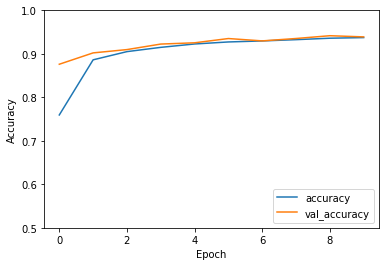

In [31]:
"Using a smaller representation size, but larger hidden layer size."

num_mix_layers = 4
in_shape = (height, width)
repr_shape = (4, 4)
out_shape = (4, 4)

model = MixerClf(in_shape, repr_shape, out_shape, num_mix_layers, hidden_size=512)

print(model.summary())
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_labels), verbose=2)

# PLOTS
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([.5, 1])
plt.legend(loc='lower right')
plt.show()

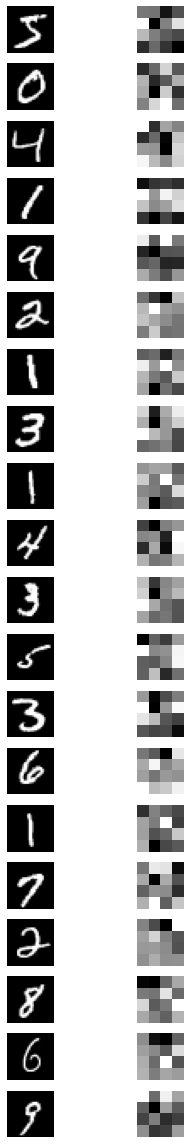

In [32]:
mixfunc = tf.keras.backend.function([model.layers[0].input], [model.layers[3].output])

plt.figure(figsize=(5, 16))
for i in range(20):
    im = train_images[i:i+1,...]
    result = mixfunc(im)[0][0,...]

    plt.subplot(20, 2, i*2+1)
    plt.imshow(im[0, ...], vmin=0, vmax=1, cmap='gray')
    plt.axis('off')

    plt.subplot(20, 2, i*2+2)
    plt.imshow(result, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

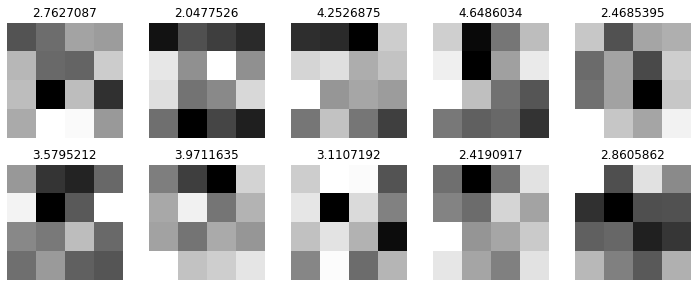

In [33]:
"Average representations per class."

avgs = []
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5, 5, i+1)
    representations = mixfunc(train_images[train_labels==i,...])[0]
    av = np.mean(representations, axis=0)
    plt.title(np.std(representations))
    plt.imshow(av, cmap='gray')

    avgs.append(av)
    plt.axis('off')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Class')

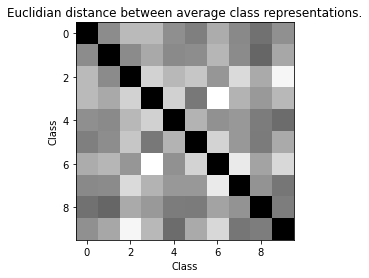

In [34]:
avgs_np = np.stack(avgs).reshape(10, -1)
diffs = (avgs_np.reshape(10, -1, 16) - avgs_np.reshape(-1, 10, 16))**2
diffs = np.sqrt(np.mean(diffs, axis=-1))
plt.imshow(diffs, cmap='gray')
plt.title('Euclidian distance between average class representations.')
plt.xlabel('Class')
plt.ylabel('Class')

# CIFAR-10

**The below code is currently out of sync
with the code above (so won't run)**

In [ ]:

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0
train_images, test_images = train_images.astype(np.float32), test_images.astype(np.float32)
height, width, channels = 32, 32, 3
num_classes = 10

170500096/170498071 [==============================] - 11s 0us/step


## Classifier

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf.compat.v1.transpose (TFOp (None, 3, 32, 32)         0         
_________________________________________________________________
dense (Dense)                (None, 3, 32, 32)         1056      
_________________________________________________________________
tf.compat.v1.transpose_1 (TF (None, 32, 32, 3)         0         
_________________________________________________________________
tf.compat.v1.transpose_2 (TF (None, 32, 3, 32)         0         
_________________________________________________________________
dense_1 (Dense)              (None, 32, 3, 32)         1056      
_________________________________________________________________
tf.compat.v1.transpose_3 (TF (None, 32, 32, 3)         0     

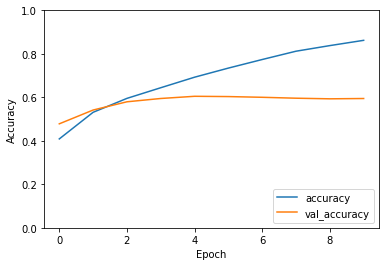

In [ ]:
num_mix_layers = 16
net = lambda outsize: MLP(outsize, hidden_size=128)
make_mixer = lambda: NdMixer([height, width, channels], net, gate=False)

inputs = tf.keras.layers.Input(shape=(height, width, channels))
linmap_in = NdMixer([height, width, channels], layers.Dense, gate=False)(inputs)
mixer_layers = ResidualLayers(num_mix_layers, make_mixer)(linmap_in)
linmap_out = NdMixer([20, 20, 1], layers.Dense, gate=False)(mixer_layers)  # make a tractable size
flat = tf.keras.layers.Flatten()(linmap_out)
y = tf.keras.layers.Dense(num_classes)(flat)
model = tf.keras.Model(inputs=inputs, outputs=y)

print(model.summary())
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_labels))

# PLOTS
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

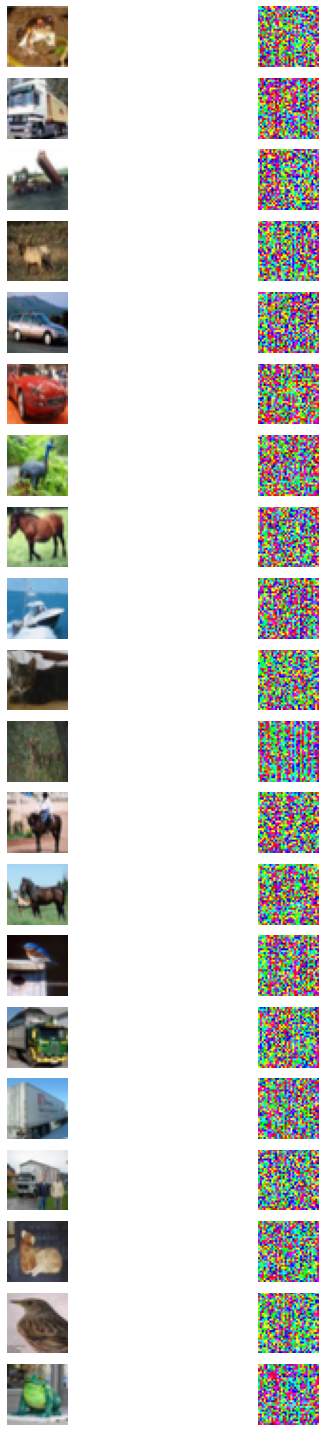

In [ ]:
plt.figure(figsize=(10, 20))
mixfunc = tf.keras.backend.function([inputs], [mixer_layers])
for i in range(20):
    im = train_images[i:i+1,...]
    pred = mixfunc(im)[0][0,...]
    pred_norm = (pred - np.mean(pred)) / np.std(pred) + 0.5
    pred_norm = np.clip(pred_norm, 0, 1)

    plt.subplot(20, 2, i*2+1)
    plt.imshow(im[0, ...], vmin=0, vmax=1)
    plt.axis('off')

    plt.subplot(20, 2, i*2+2)
    plt.imshow(pred_norm)
    plt.axis('off')

plt.tight_layout()
plt.show()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf.compat.v1.transpose_24 (T (None, 3, 32, 32)         0         
_________________________________________________________________
dense_154 (Dense)            (None, 3, 32, 128)        4224      
_________________________________________________________________
tf.compat.v1.transpose_25 (T (None, 128, 32, 3)        0         
_________________________________________________________________
tf.compat.v1.transpose_26 (T (None, 128, 3, 32)        0         
_________________________________________________________________
dense_155 (Dense)            (None, 128, 3, 128)       4224      
_________________________________________________________________
tf.compat.v1.transpose_27 (T (None, 128, 128, 3)       0   

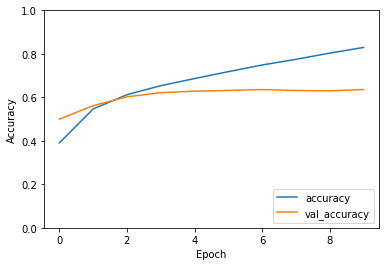

In [ ]:
"With linear mapping to modify the size of the hidden representation (and therefore MLP size)."
num_mix_layers = 4
repheight, repwidth = 128, 128
net = lambda outsize: MLP(outsize, hidden_size=outsize)
make_mixer = lambda: NdMixer([repheight, repwidth, channels], net, gate=False)

inputs = tf.keras.layers.Input(shape=(height, width, channels))
linmap_in = NdMixer([repheight, repwidth, channels], layers.Dense, gate=False)(inputs)
mixer_layers = ResidualLayers(num_mix_layers, make_mixer)(linmap_in)
linmap_out = NdMixer([20, 20, 1], layers.Dense, gate=False)(mixer_layers)  # make a tractable size
flat = tf.keras.layers.Flatten()(linmap_out)
y = tf.keras.layers.Dense(num_classes)(flat)
model = tf.keras.Model(inputs=inputs, outputs=y)

print(model.summary())
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_labels))

# PLOTS
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

## Autoencoder

Note that skip connections are removed for the autoencoder model, because they would cause the model to be initialised as the identity function, (due to the initial 0 scalar gate), which would make the model trivially an autoencoder.

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
layers_2 (Layers)            (None, 32, 32, 3)         8496      
Total params: 8,496
Trainable params: 8,496
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
782/782 [==============================] - 9s 10ms/step - loss: 0.0707 - root_mean_squared_error: 0.2532 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0963
Epoch 2/10
782/782 [==============================] - 7s 10ms/step - loss: 0.0077 - root_mean_squared_error: 0.0878 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0631
Epoch 3/10
782/782 [==============================] - 7s 10ms/step - loss: 0.0035 - root_mean_squared_error: 0.0588 - val_loss: 0.0024 - val_root_mean_squared_error: 0.

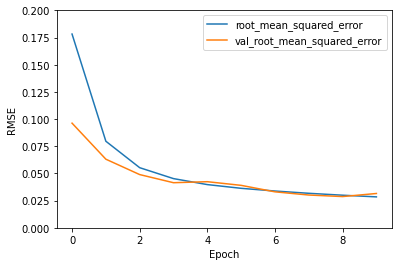

In [ ]:
num_mix_layers = 2
Net = lambda outsize: MLP(outsize, hidden_size=outsize)
make_mixer = lambda: NdMixer([height, width, channels], Net, gate=False)

inputs = tf.keras.layers.Input(shape=(height, width, channels))
mixer_layers = Layers(num_mix_layers, make_mixer)(inputs)
model = tf.keras.Model(inputs=inputs, outputs=mixer_layers)

print(model.summary())
model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(train_images, train_images, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_images))

plt.plot(history.history['root_mean_squared_error'], label='root_mean_squared_error')
plt.plot(history.history['val_root_mean_squared_error'], label = 'val_root_mean_squared_error')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.ylim([0, .2])
plt.legend()
test_loss, test_acc = model.evaluate(test_images,  test_images, verbose=2)

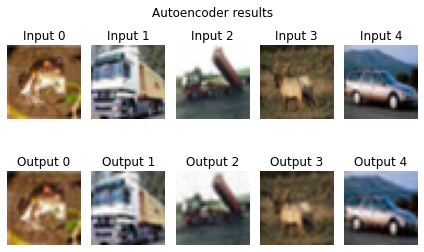

In [ ]:
for i in range(5):
    im = train_images[i:i+1, ...]
    pred = model.predict(im)[0,...]
    pred = np.clip(pred, 0, 1)

    plt.subplot(2, 5, i+1)
    plt.imshow(im[0,:,:], cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.title(f'Input {i}')

    plt.subplot(2, 5, i+6)
    plt.imshow(pred, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.title(f'Output {i}')

plt.suptitle("Autoencoder results")
plt.tight_layout()
plt.show()